In [9]:
# reload magics
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import log10

from project_modules.utils import get_logger
logger = get_logger("log-data-umap.log")
# read the parameter file

from project_modules.utils import read_parameters
parms = read_parameters("/Users/david/projects/lc-project-data/project.yaml")

[2024-02-02 21:34:51] [get_logger] Logger initialized.
[2024-02-02 21:34:51] [get_logger] Logging to file: log-data-umap.log
[2024-02-02 21:34:51] [read_parameters] Reading parameters.
[2024-02-02 21:34:51] [read_parameters] ... reading /Users/david/projects/lc-project-data/project.yaml


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# TODO

# enum?



In [11]:
# make blobs using sklearn
from sklearn.datasets import make_blobs, make_classification
from sklearn.preprocessing import StandardScaler, MinMaxScaler

SAMPLES = 1_000
FEATURES = 25

# make blobs
X, y = make_classification(n_samples=SAMPLES, n_features=FEATURES, n_informative = 5)


# scale the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)



# make a 2d plot of the blobs

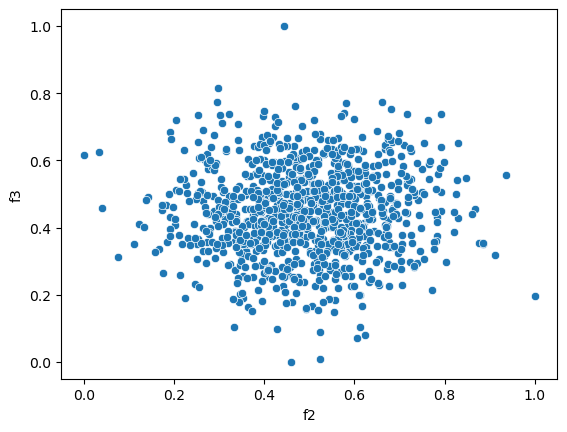

In [12]:
# plot the first two features on a sns scatter plot
df = pd.DataFrame(X, columns=[f"f{i}" for i in range(FEATURES)])
# df["label"] = y
# df["label"] = df["label"].astype("category")

# plot the first two features
sns.scatterplot(data=df, x="f2", y="f3")
plt.show()

In [13]:
# split the synetetic data into a train set, test set, and holdout set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [14]:
# fit a umap model to the training data
import umap
umap_model = umap.UMAP(n_neighbors=15, 
                       n_components=2, 
                       metric = "euclidean",
                         min_dist=0.1)
umap_model.fit(X_train)

# transform the training data
X_train_umap = umap_model.transform(X_train)

# use hdbscan clustering to label the training data
import hdbscan
clusterer = hdbscan.HDBSCAN(
                                min_cluster_size=15, 
                                min_samples=5, 
                                prediction_data=True, 
                                cluster_selection_method="eom"
                            )

clusterer.fit(X_train_umap)



HDBSCAN(min_cluster_size=15, min_samples=5, prediction_data=True)

In [20]:

# apply the same umap_mdel to the test data and predict cluster membership
X_test_umap = umap_model.transform(X_test)
y_test_pred = hdbscan.approximate_predict(clusterer, X_test_umap)
# y_test_pred = np.argmax(hdbscan.prediction.membership_vector(clusterer, X_test_umap), axis = 1)

# apply the same umap_mdel to the holdout data and predict cluster membership
X_holdout_umap = umap_model.transform(X_holdout)
y_holdout_pred = hdbscan.approximate_predict(clusterer, X_holdout_umap)

df_test = pd.DataFrame(X_test_umap, columns=["umap1", "umap2"])
df_test["label"] = y_test_pred[0]

df_holdout = pd.DataFrame(X_holdout_umap, columns=["umap1", "umap2"])
df_holdout["label"] = y_holdout_pred[0]



In [23]:
# plot the first two features on a sns scatter plot
df = pd.DataFrame(X_train_umap, columns=[f"f{i}" for i in range(umap_model.n_components)])
# df["label"] = np.argmax(hdbscan.prediction.membership_vector(clusterer, X_train_umap), axis = 1)
df["label"] = df["label"].astype("category")

# plot the first two features
sns.scatterplot(data=df, x="f0", y="f1", hue="label", palette= "tab10", s=24, alpha=0.275)
sns.scatterplot(data = df_test, x="umap1", y="umap2", hue="label", marker="s", s=40, palette=  "tab10")
# sns.scatterplot(data = df_holdout, x="umap1", y="umap2", hue="label", marker="^", s=10, palette=  "tab10")


plt.show()

KeyError: 'label'

In [28]:
# modelling

In [30]:
# build an RFC model on the train set

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# evaluate the model on the test set
from sklearn.metrics import accuracy_score
y_test_pred = rfc.predict(X_test)
print(f"Evaluation on test set: {accuracy_score(y_test, y_test_pred)}")

# evaluate the model on the holdout set
y_holdout_pred = rfc.predict(X_holdout)
print(f"Evaluation on holdout set: {accuracy_score(y_holdout, y_holdout_pred)}")


Evaluation on test set: 1.0
Evaluation on holdout set: 1.0
